# This is a scratch space for building functions
After functions are made, move them to the corresponding folder. 

In [6]:
from pathlib import Path
from flow_analysis_comps.PIV.PIV_process import AMF_PIV
from flow_analysis_comps.PIV.definitions import PIV_params, segmentMode

In [7]:
data_adr = Path(r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine")
plate_id = r"20250122_Plate017"
video_id = r"031"
frame_id1 = r"Img/Img_00000.tif"
frame_id2 = r"Img/Img_00001.tif"

mode = "BRIGHTFIELD"
# mode = "FLUO"

fps = 20
t_dt = 1/fps
winsize = 8 # pixels, interrogation window size in frame A
searchsize = 12  # pixels, search area size in frame B
overlap = 3 # pixels
dt = t_dt # sec, time interval between the two frames
frame_ids = (0,5)

STN_thresh = 1.05

piv_param_obj = PIV_params(
    video_path=data_adr/video_id,
    segment_mode=segmentMode.BRIGHT,
    fps=fps,
    window_size=winsize,
    search_size=searchsize,
    overlap_size=overlap,
    stn_threshold=STN_thresh,
    px_per_mm= 1500/2
)

Found 200 images in target directory.
8 117
51.157858005158126
9 120
54.164863008216166


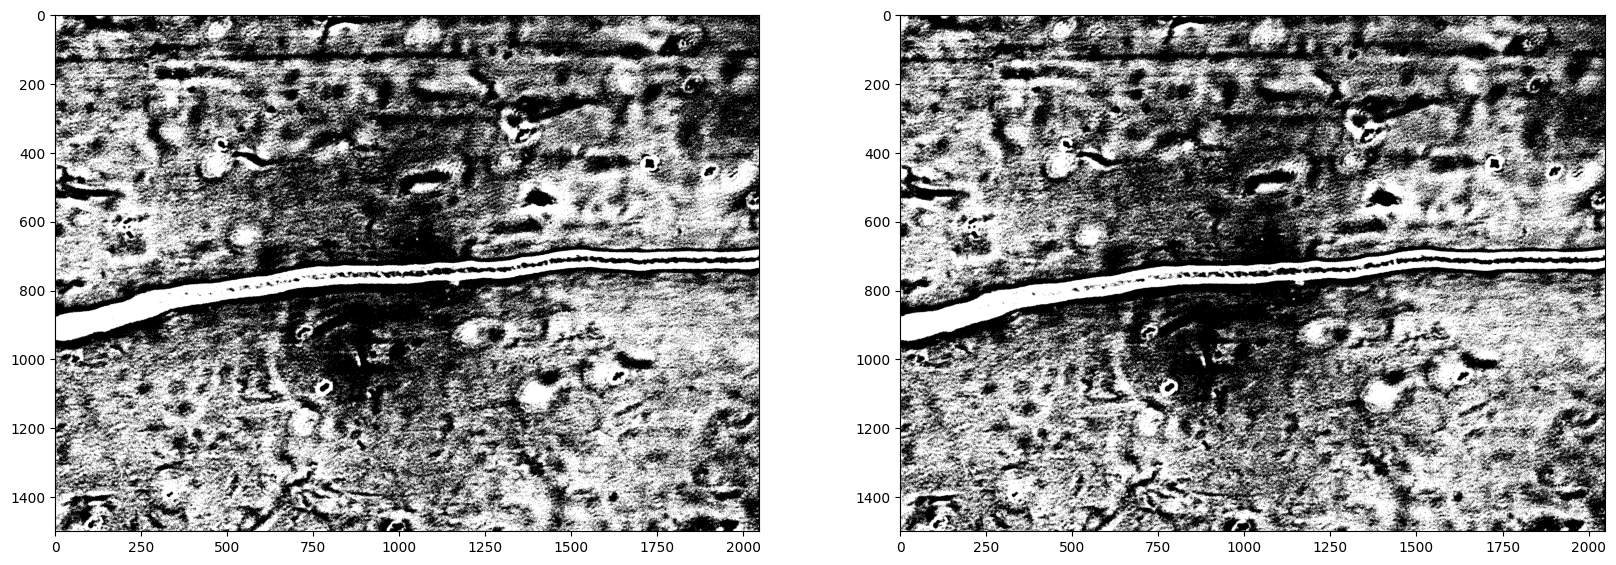

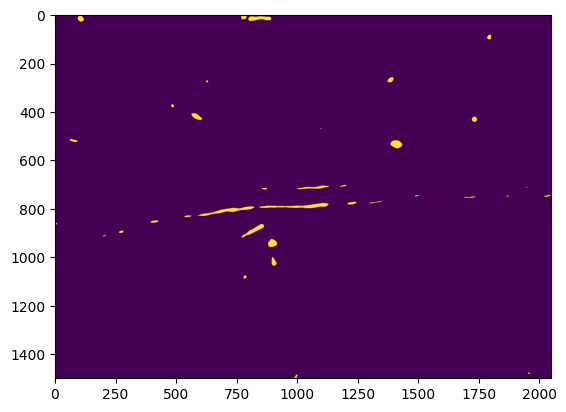

In [8]:
amf_piv_obj = AMF_PIV(piv_param_obj)
amf_piv_obj.plot_raw_images(frame_ids)
amf_piv_obj.plot_segmentation()

8 117
38.04872130300141
9 120
41.23704844504545


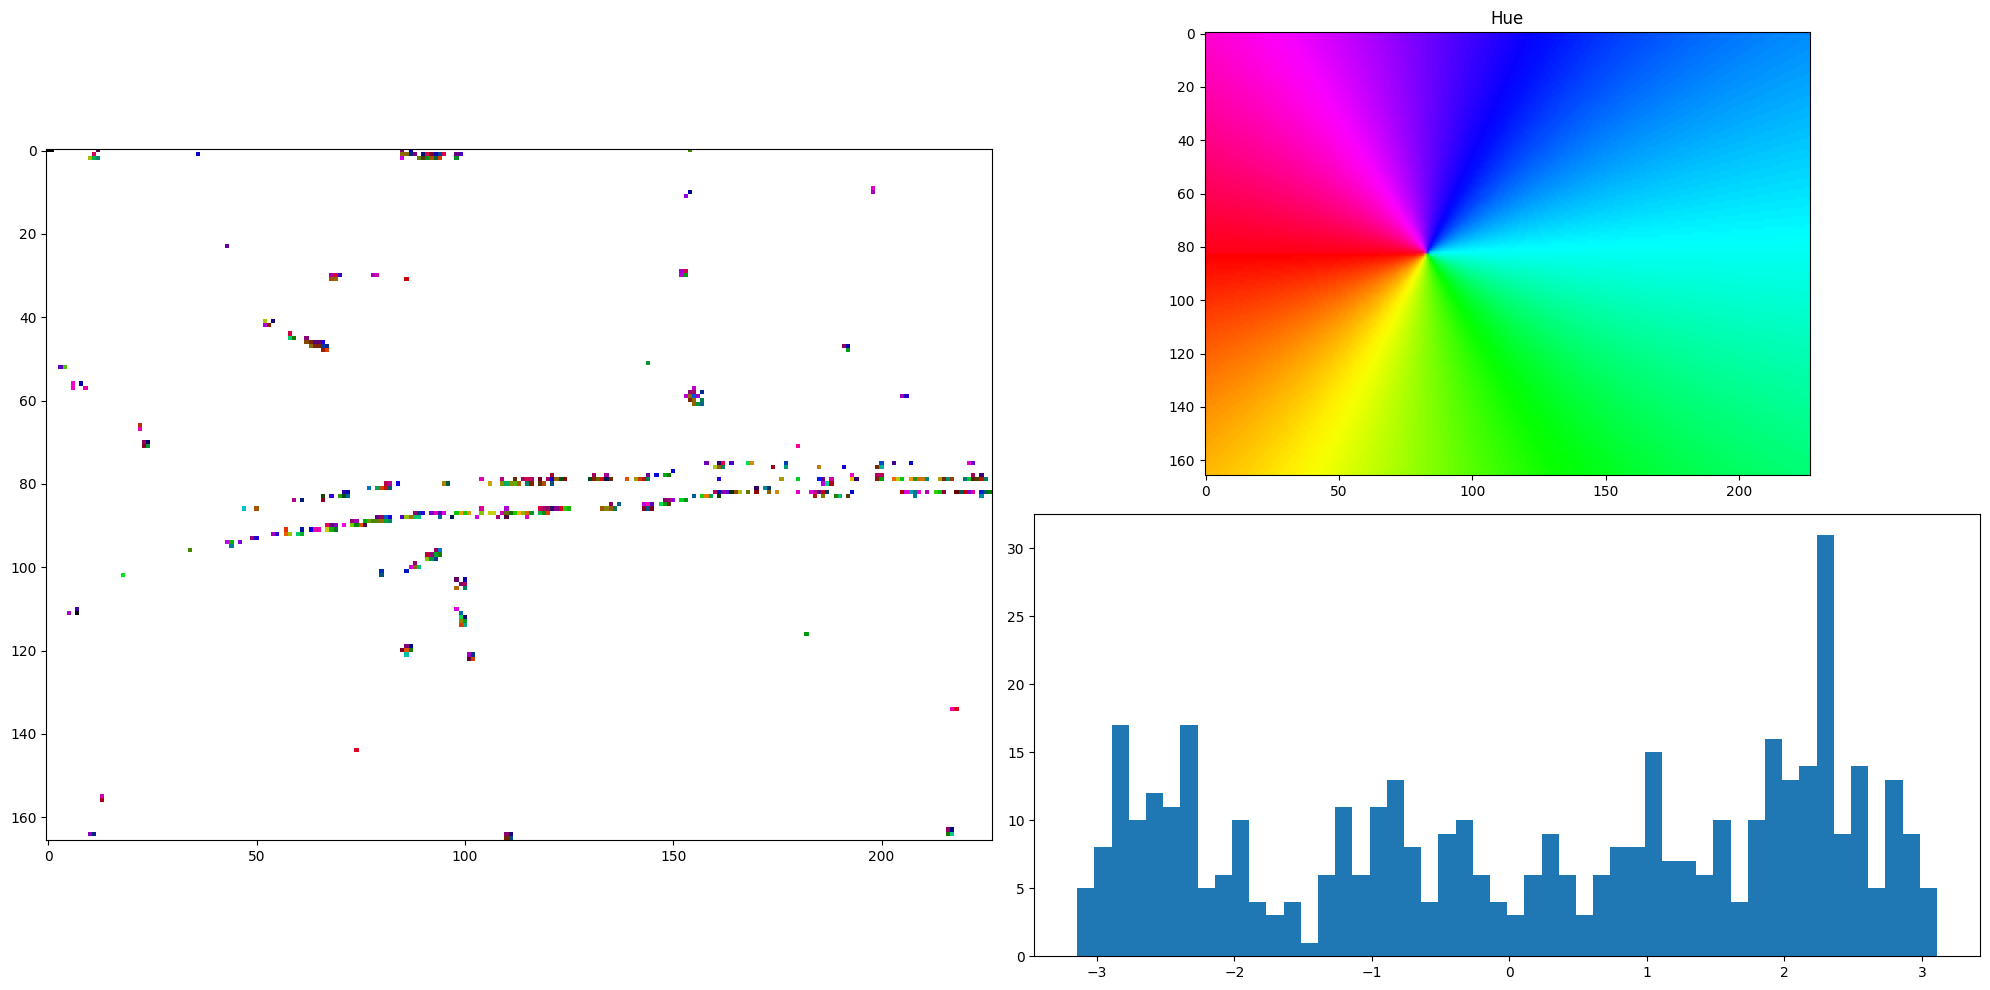

In [9]:
amf_piv_obj.piv_process(frame_ids, FAKE_OUTLIERS=False)
amf_piv_obj.plot_results_color()

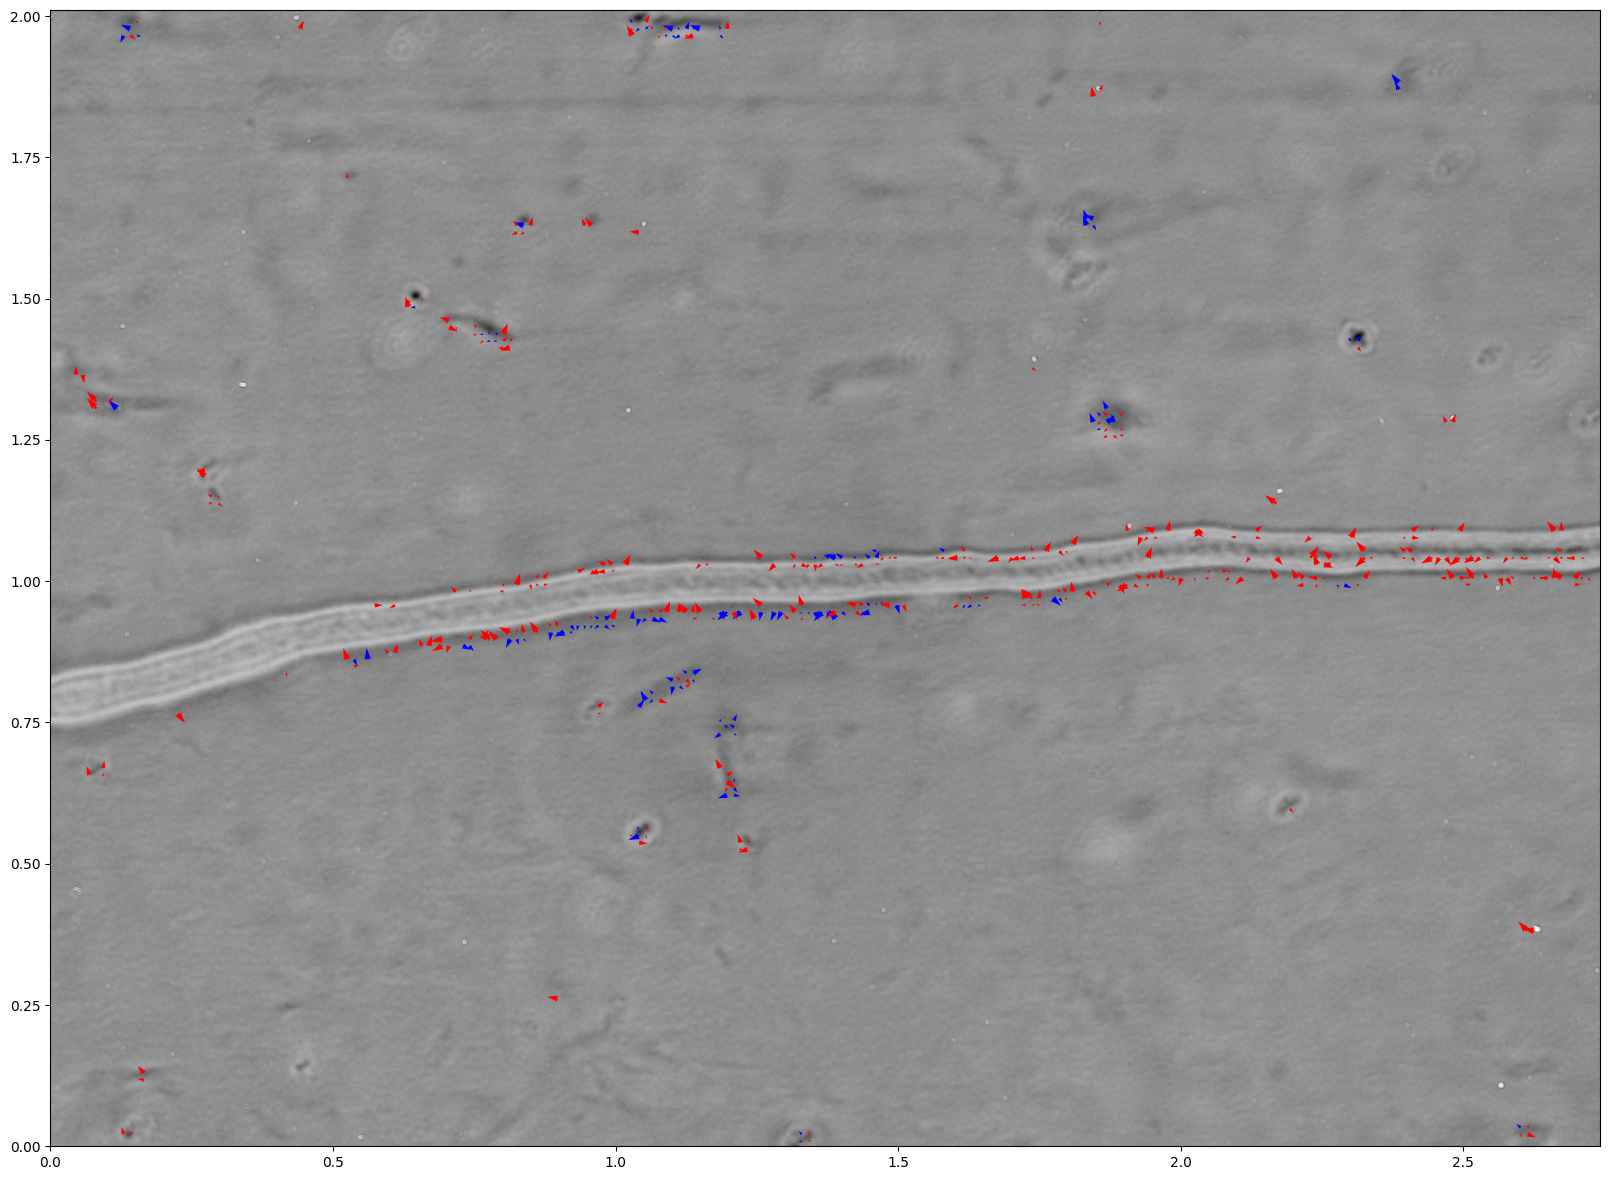

In [10]:
amf_piv_obj.plot_results_arrows()